# Correlation between COVID-19 infections and the weather
University project where we investigated whether there is a statistical association between different weather conditions
and confirmed COVID-19 cases in Sweden in 2020.

by Ada Matilde Gige, Moneeca Abru Iftikhar Latif, Sabrina Fonseca Pereira, Sofie Pedersen, Yasmin Sarkhosh

# Imports

In [1]:
import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import folium 
from folium import plugins
from folium.plugins import HeatMap, MarkerCluster
import math
import scipy
from scipy import stats
import statsmodels.api as sm
import pylab 

# Loading the data

In [67]:
# raw data sets provided
# read in csv files
COVID = pd.read_csv('../data/raw/corona/se_corona.csv', delimiter='\t', encoding = 'utf-8')
w1 = pd.read_csv('../data/raw/weather/weather.csv', delimiter='\t', encoding = 'utf-8')
w2 = pd.read_csv('../data/raw/weather/weather2.csv', delimiter='\t', encoding = 'utf-8')

WEATHER = w1.join(w1['iso3166-2'].str.split('-', 1, expand=True).rename(columns={0:'CountryCode', 1:'RegionCode'}))
w2 = w2.join(w2['iso3166-2'].str.split('-', 1, expand=True).rename(columns={0:'CountryCode', 1:'RegionCode'}))

WEATHER2 = pd.concat([WEATHER, w2])

# read in json file
with open('../data/raw/metadata/se_metadata.json', encoding = 'utf-8') as json_file: 
    META = json.load(json_file)

# turn json file into a dataframe
META_DF = pd.json_normalize(META,'country_metadata') 

# geojason
GEO = "../data/raw/shapefiles/se.geojson"

/tmp/ipykernel_8237/2670409810.py:7: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  WEATHER = w1.join(w1['iso3166-2'].str.split('-', 1, expand=True).rename(columns={0:'CountryCode', 1:'RegionCode'}))
/tmp/ipykernel_8237/2670409810.py:8: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  w2 = w2.join(w2['iso3166-2'].str.split('-', 1, expand=True).rename(columns={0:'CountryCode', 1:'RegionCode'}))


In [3]:
# making a dict where the key is the region code and the value is the region name
LABELS = dict()
for i in range(len(META['country_metadata'])):
    LABELS[META['country_metadata'][i]['iso3166-2_code']] = META['country_metadata'][i]['iso3166-2_name_en']

print(LABELS)

{'SE-AB': 'Stockholm', 'SE-AC': 'Västerbotten', 'SE-BD': 'Norrbotten', 'SE-C': 'Uppsala', 'SE-D': 'Södermanland', 'SE-E': 'Östergötland', 'SE-F': 'Jönköping', 'SE-G': 'Kronoberg', 'SE-H': 'Kalmar', 'SE-I': 'Gotland', 'SE-K': 'Blekinge', 'SE-M': 'Skåne', 'SE-N': 'Halland', 'SE-O': 'Västra_Götaland', 'SE-S': 'Värmland', 'SE-T': 'Örebro', 'SE-U': 'Västmanland', 'SE-W': 'Dalarna', 'SE-X': 'Gävleborg', 'SE-Y': 'Västernorrland', 'SE-Z': 'Jämtland'}


In [4]:
# external datasets from https://www.folkhalsomyndigheten.se/folkhalsorapportering-statistik/ 
REGIONS = pd.read_csv('..//data//external//hospitalised_and_deaths_Sweden.csv', encoding = "latin-1")
AGE =  pd.read_csv('..//data//external//age_of_cases.csv', encoding = 'utf-8')
GENDER = pd.read_csv('..//data//external//gender_of_cases.csv', encoding = 'utf-8')

# Inspection of raw data sets
Here we look at the shape of data, for possible missing values, etc.

In [5]:
COVID.shape
print(f'There are {COVID.shape[0]} rows in the se_corona table and {COVID.shape[1]} columns.')

# Checking for any missing data in the weather.csv
if COVID.isnull().values.any() == False:
    print('There are no missing values in the COVID table')
else:
    print('There are missing values in the COVID table')

There are 8001 rows in the se_corona table and 3 columns.
There are no missing values in the COVID table


In [6]:
WEATHER.shape
print(f'There are {WEATHER.shape[0]} rows in the weather table and {WEATHER.shape[1]} columns.')

# Checking for any missing data in the weather.csv
if WEATHER.isnull().values.any() == False:
    print('There are no missing values in the weather table')
else:
    print('There are missing values in the weather table')

There are 14904 rows in the weather table and 11 columns.
There are no missing values in the weather table


# Merging the data sets
1. Started by filtering the weather data to Sweden only
2. Merged weather data with the metadata for population count and region names
3. Merged that to the the COVID dataset.

In [7]:
# create new column with the tempareture in celcius
WEATHER["TempCelc"] = WEATHER['TemperatureAboveGround'] - 273.15

# filtering out weather data for Sweden
WEATHER_SE = WEATHER[WEATHER['CountryCode'] == 'SE']

# Checking if it worked
WEATHER_SE['iso3166-2'].unique()

array(['SE-AB', 'SE-AC', 'SE-BD', 'SE-C', 'SE-D', 'SE-E', 'SE-F', 'SE-G',
       'SE-H', 'SE-I', 'SE-K', 'SE-M', 'SE-N', 'SE-O', 'SE-S', 'SE-T',
       'SE-U', 'SE-W', 'SE-X', 'SE-Y', 'SE-Z'], dtype=object)

In [8]:
# first merge of weather and metadata
weather_covid = pd.merge(WEATHER_SE, META_DF, left_on='iso3166-2', right_on='iso3166-2_code').drop(['iso3166-2_code'], axis=1)

# duplicate columns to be dropped after merge
col_drop = ['CountryCode', 'RegionCode', 'covid_region_code', 'region_code']

# all columns merged 
ALLTABLES = pd.merge(weather_covid, COVID, left_on=['date', 'covid_region_code'], right_on=['date', 'region_code'], how='left').drop(col_drop, axis=1)

# function to get logs and if zero returns none
def get_log(x):
    if x == 0:
        return 0
    else:
        return np.log2(x)

# create new column with log values of cases
ALLTABLES['log_cases'] = ALLTABLES.confirmed_addition.apply(lambda x : get_log(x))

ALLTABLES['cases_percapita'] =  ALLTABLES['confirmed_addition'] / ALLTABLES['population'] 

ALLTABLES['date'] =  pd.to_datetime(ALLTABLES['date']) # change column into pandas datetime for aggregation
# ALLTABLES['year'] =  ALLTABLES['date'].dt.year # new column with month name
ALLTABLES['month'] =  ALLTABLES['date'].dt.month # new column with month number
ALLTABLES['week'] =  ALLTABLES['date'].dt.isocalendar().week.astype('int32') # new column with week number

# ALLTABLES['year_month'] = ALLTABLES['year'].astype("str") + '-' + ALLTABLES['month'].astype("str")
# ALLTABLES['year_week'] = ALLTABLES['year'].astype("str") + '-' + ALLTABLES['week'].astype("str")

# check for missing values in the merged data frame
if ALLTABLES.isnull().values.any() == False:
    print('There are no missing values in the weather table')
else:
    print('There are missing values in the weather table')

There are no missing values in the weather table


In [9]:
# checking for zero values in the data
ALLTABLES.isin([0]).sum()

date                          0
iso3166-2                     0
RelativeHumiditySurface       0
SolarRadiation                0
Surfacepressure               0
TemperatureAboveGround        0
Totalprecipitation          541
UVIndex                     500
WindSpeed                     0
TempCelc                      0
iso3166-1_code                0
iso3166-1_name                0
iso3166-2_name_en             0
population                    0
confirmed_addition         1030
log_cases                  1434
cases_percapita            1030
month                         0
week                          0
dtype: int64

## Inpecting new dataframes for possible data loss
We lost 2205 days from the COVID dataframe by merging it to the weather data which included less days.

In [10]:
tables = [WEATHER_SE, COVID, ALLTABLES]
table_names = ['WEATHER_SE','COVID','ALLTABLES']

for i in range(len(tables)):
    print("There are " + str(tables[i].shape[0]) + " rows in the " + table_names[i] + " table.")

There are 5796 rows in the WEATHER_SE table.
There are 8001 rows in the COVID table.
There are 5796 rows in the ALLTABLES table.


# Analyzing the data

## Weather variables
Calculate min, mean, median, and max of all numeric weather variables grouped by region.

In [11]:
# select only numerical columns and group by region
num_cols = WEATHER_SE.iloc[:, 1:9].groupby('iso3166-2', as_index=False)

# min, mean, median, and max
num_var_min = num_cols.min()
num_var_mean = num_cols.mean()
num_var_median = num_cols.median()
num_var_max = num_cols.max()

# little peek in the data
num_var_mean.head()

iso3166-2  RelativeHumiditySurface  SolarRadiation  Surfacepressure  \
0     SE-AB                72.086453    8.688452e+06     2.420815e+06   
1     SE-AC                74.573449    6.631244e+06     2.306597e+06   
2     SE-BD                74.263827    6.101938e+06     2.289074e+06   
3      SE-C                72.700879    8.065640e+06     2.418581e+06   
4      SE-D                69.945793    8.156330e+06     2.416591e+06   

   TemperatureAboveGround  Totalprecipitation    UVIndex  WindSpeed  
0              283.643340            0.001660  17.822844   3.738618  
1              278.344607            0.002435  11.848619   2.996518  
2              276.814870            0.002589  10.687614   3.139086  
3              283.269811            0.001669  16.595615   3.239275  
4              284.181619            0.001826  17.883298   3.448074

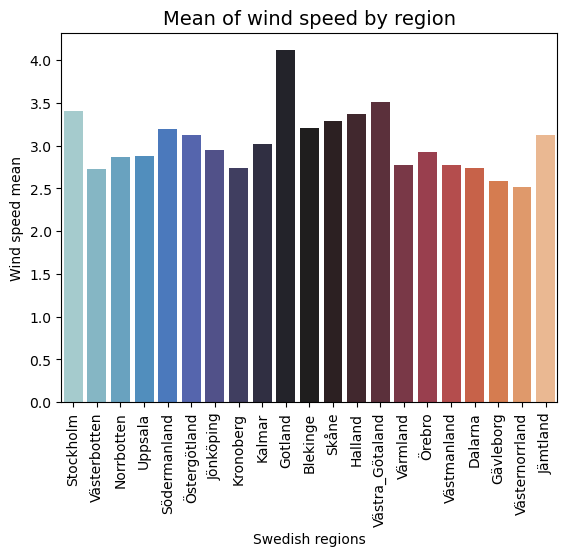

In [12]:
# plotting one of the variables
regions = list(LABELS.values())

fig = sns.barplot(x='iso3166-2',y='WindSpeed', data=num_var_median, palette="icefire")
plt.xlabel("Swedish regions")
plt.ylabel("Wind speed mean")
plt.title("Mean of wind speed by region", size=14)
fig.set_xticklabels(labels=regions, rotation=90)

plt.show(fig)

## Weather variations across time
Single weather variables mean values with time aggregation

In [13]:
mean_month = ALLTABLES.groupby(ALLTABLES['month'], sort=False).mean()
mean_month # mean of temperatures across months

/tmp/ipykernel_8237/1466658609.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_month = ALLTABLES.groupby(ALLTABLES['month'], sort=False).mean()


RelativeHumiditySurface  SolarRadiation  Surfacepressure  \
month                                                             
2                    81.917670    2.181212e+06     2.341697e+06   
3                    73.093534    5.075753e+06     2.378933e+06   
4                    62.027525    9.856137e+06     2.382163e+06   
5                    64.969779    1.231036e+07     2.386565e+06   
6                    64.456546    1.502730e+07     2.385778e+06   
7                    75.314806    1.008647e+07     2.372118e+06   
8                    73.194655    1.023802e+07     2.381757e+06   
9                    81.079937    5.026568e+06     2.380318e+06   
10                   87.954078    1.553838e+06     2.372519e+06   
11                   88.266417    6.342159e+05     2.390647e+06   

       TemperatureAboveGround  Totalprecipitation    UVIndex  WindSpeed  \
month                                                                     
2                  273.463110            0.002657   1.284228   4.493124   
3                  274.533611            0.001614   5.506979   3.930284   
4                  278.304073            0.000927  14.935670   3.994365   
5                  281.279809            0.001532  24.182167   3.185374   
6                  289.911430            0.002120  34.075472   2.776646   
7                  287.510456            0.003758  29.202591   3.196219   
8                  289.473593            0.001596  24.874180   2.397835   
9                  284.881219            0.001757  11.578024   3.190513   
10                 280.439378            0.003294   2.743098   3.105622   
11                 279.571132            0.001526   0.088848   3.248317   

        TempCelc     population  confirmed_addition  log_cases  \
month                                                            
2       0.313110  491789.952381            0.036415   0.012843   
3       1.383611  491789.952381            7.403994   1.440111   
4       5.154073  491789.952381           26.622222   3.482017   
5       8.129809  491789.952381           26.196621   3.523833   
6      16.761430  491789.952381           46.358730   4.075618   
7      14.360456  491789.952381           13.943164   2.479509   
8      16.323593  491789.952381           11.453149   2.162024   
9      11.731219  491789.952381           14.985714   2.542265   
10      7.289378  491789.952381           58.666667   4.137639   
11      6.421132  491789.952381          191.972789   6.380147   

       cases_percapita       week  
month                              
2         3.675555e-08   8.117647  
3         1.239305e-05  11.580645  
4         5.026111e-05  15.933333  
5         5.143368e-05  20.258065  
6         8.381438e-05  24.666667  
7         2.842869e-05  29.000000  
8         2.069937e-05  33.419355  
9         2.806811e-05  37.800000  
10        1.021427e-04  42.129032  
11        3.566692e-04  45.357143

## COVID-19 case count across time

/tmp/ipykernel_8237/4212147511.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[0], x=ALLTABLES['month'], y='confirmed_addition', data=ALLTABLES, palette="mako", estimator='sum')
/tmp/ipykernel_8237/4212147511.py:11: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[1], x=ALLTABLES['week'], y='confirmed_addition', data=ALLTABLES, palette="mako", estimator='sum')
/tmp/ipykernel_8237/4212147511.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(ax=axes[2], x=ALLTABLES['date'], y='confirmed_addition', data=ALLTABLES, palette="mako", estimator='sum')


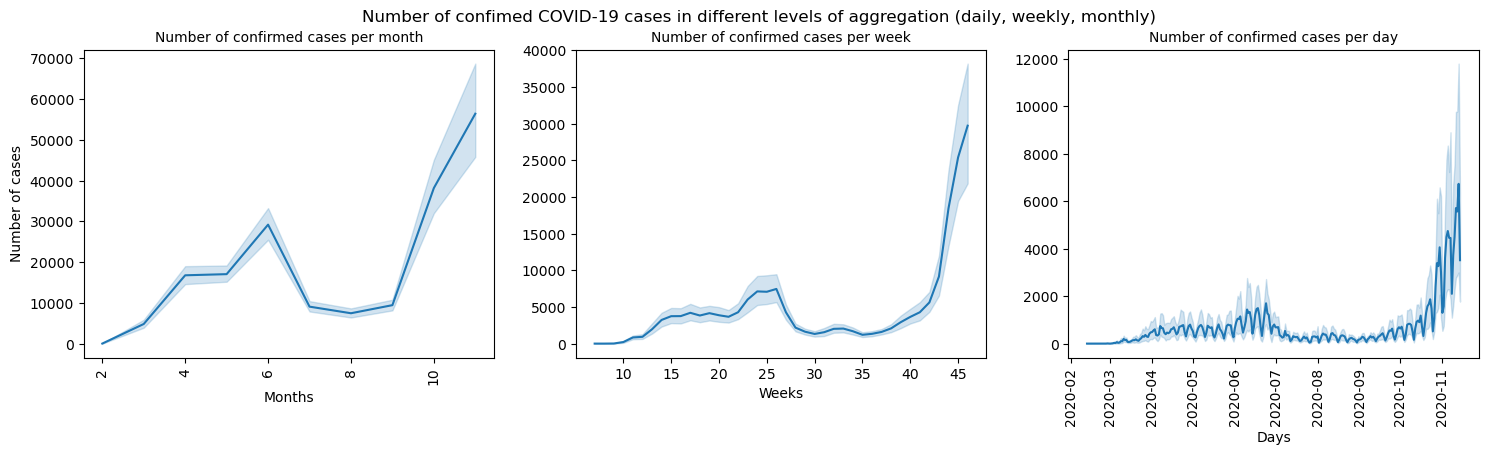

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

fig.suptitle('Number of confimed COVID-19 cases in different levels of aggregation (daily, weekly, monthly)\n', size=12)

sns.lineplot(ax=axes[0], x=ALLTABLES['month'], y='confirmed_addition', data=ALLTABLES, palette="mako", estimator='sum')
axes[0].set_xlabel("Months")
axes[0].set_ylabel("Number of cases")
axes[0].set_title("Number of confirmed cases per month", size=10)
axes[0].tick_params(labelrotation=90, axis='x')

sns.lineplot(ax=axes[1], x=ALLTABLES['week'], y='confirmed_addition', data=ALLTABLES, palette="mako", estimator='sum')
axes[1].set_xlabel("Weeks")
axes[1].set_ylabel(" ")
axes[1].set_title("Number of confirmed cases per week", size=10)

sns.lineplot(ax=axes[2], x=ALLTABLES['date'], y='confirmed_addition', data=ALLTABLES, palette="mako", estimator='sum')
axes[2].set_xlabel("Days")
axes[2].set_ylabel(" ")
axes[2].set_title("Number of confirmed cases per day", size=10)
axes[2].tick_params(labelrotation=90, axis='x')

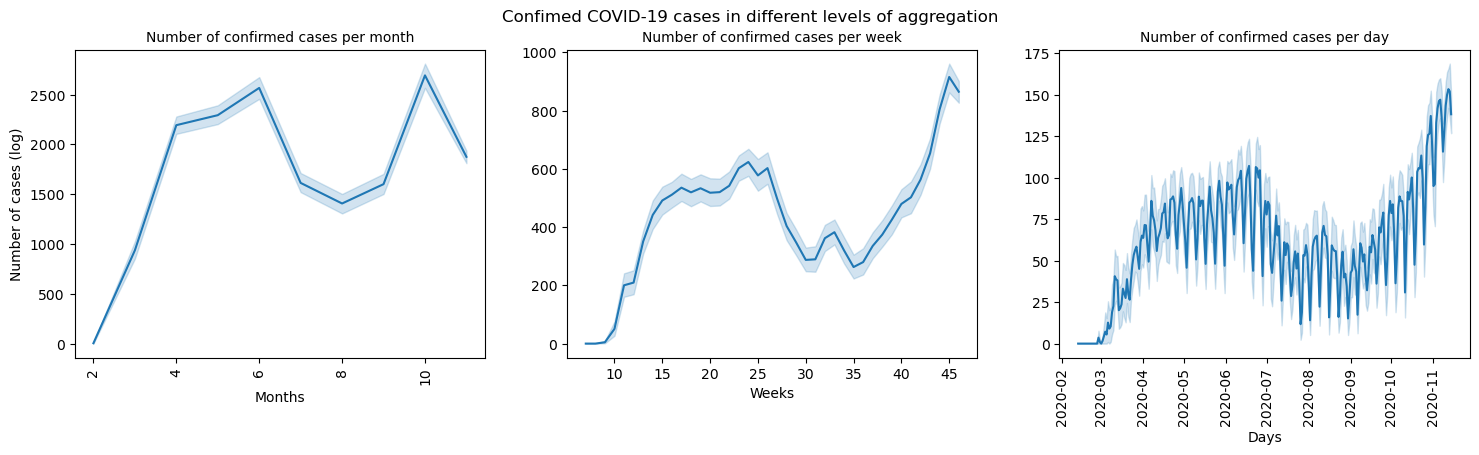

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

fig.suptitle('Confimed COVID-19 cases in different levels of aggregation', size=12)

sns.lineplot(ax=axes[0], x=ALLTABLES['month'], y='log_cases', data=ALLTABLES, estimator='sum')
axes[0].set_xlabel("Months")
axes[0].set_ylabel("Number of cases (log)")
axes[0].set_title("Number of confirmed cases per month", size=10)
axes[0].tick_params(labelrotation=90, axis='x')

sns.lineplot(ax=axes[1], x=ALLTABLES['week'], y='log_cases', data=ALLTABLES, estimator='sum')
axes[1].set_xlabel("Weeks")
axes[1].set_ylabel(" ")
axes[1].set_title("Number of confirmed cases per week", size=10)

sns.lineplot(ax=axes[2], x=ALLTABLES['date'], y='log_cases', data=ALLTABLES, estimator='sum')
axes[2].set_xlabel("Days")
axes[2].set_ylabel(" ")
axes[2].set_title("Number of confirmed cases per day", size=10)
axes[2].tick_params(labelrotation=90, axis='x')

## Scatter plots
Visualising the relationship of the weather variables with the number of confirmed cases per day.

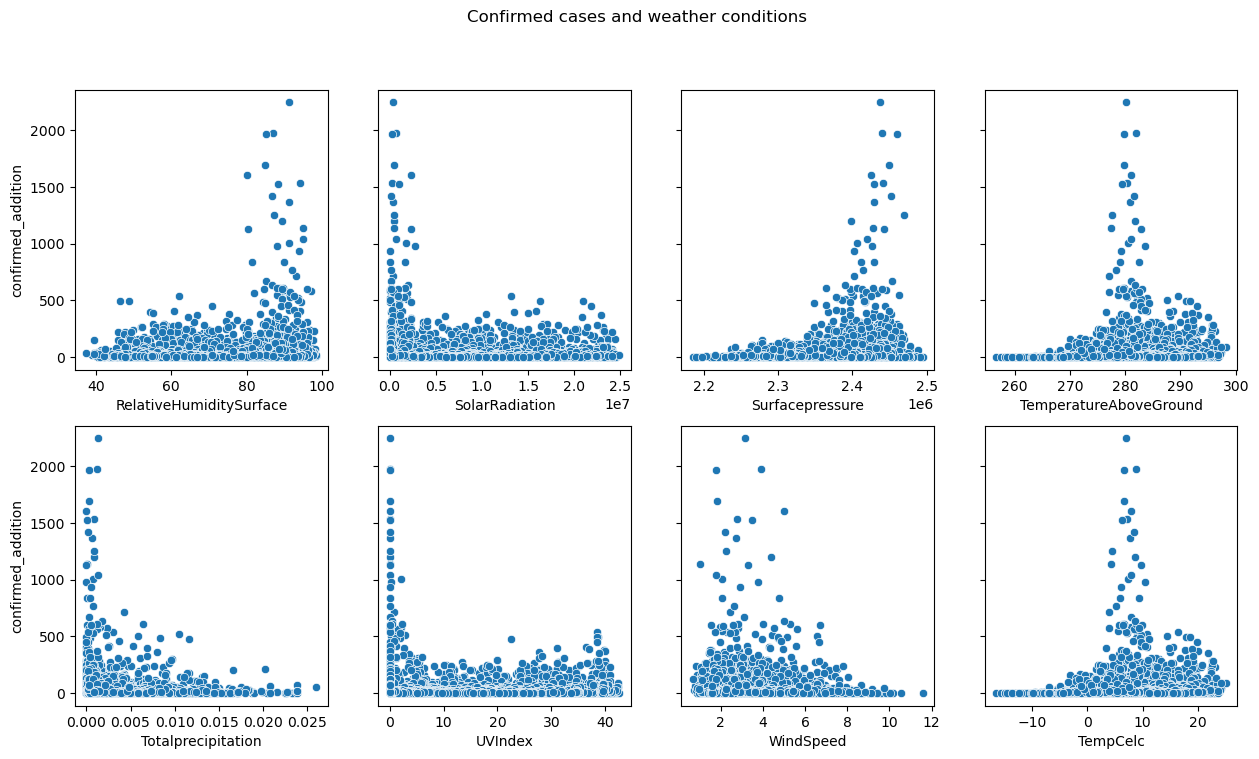

In [42]:
weathercond = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed', 'TempCelc']

fig, axes = plt.subplots(2, 4, figsize=(15, 8), sharey = True )
fig.suptitle('Confirmed cases and weather conditions')


for i in range(4):
    sns.scatterplot(ax= axes[0, i], y ='confirmed_addition', x =weathercond[i] , data = ALLTABLES)
    
for i in range(4,8):
    sns.scatterplot(ax= axes[1, i-4], y ='confirmed_addition', x = weathercond[i], data = ALLTABLES)

# Correlation tests

### Pearson
Done to look for linear relationships between numeric variables in the dataset.

### Spearman
Done to look for monotonic relationships between numeric variables in the dataset.

### Pearson on log of case numbers
Done to reduce skewness in the confirmed cases.

## Functions for correlations test

In [43]:
def Pearson(weather):
    '''A function to find the Pearson correlation and p value for the confirmed Covid-19 cases and the different weather 
    variables.'''
    corr, pval = scipy.stats.pearsonr(ALLTABLES['confirmed_addition'], ALLTABLES[weather])
    return corr, pval

def logtransformation(weather):
    '''A function to find the Pearson correlation and p value for the logtransformed confirmed Covid-19 cases and the 
    different weather variables.'''
    cases = np.log(ALLTABLES['confirmed_addition'], where = (ALLTABLES['confirmed_addition'] != 0))
    corr, pval = scipy.stats.pearsonr(cases, ALLTABLES[weather])
    return corr, pval

def Spearmanrank(weather):
    '''A function to calculate the Spearman correlation for the confirmed Covid-19 cases and the different weather variables.'''
    corr, pval = scipy.stats.spearmanr(ALLTABLES['confirmed_addition'], ALLTABLES[weather])
    return corr, pval

## Correlation tests results

In [44]:
# list of all varaibles to run correlation tests
weathercond = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']

# list of dicts with results
result_table = [] 

# run Pearson, Spearman and the Pearson log transformation on all weather variables
for i in weathercond: 
    pcorr, ppval = Pearson(i)
    scorr, spval = Spearmanrank(i)
    corr, pval = logtransformation(i)
    pval = round(ppval, 5)
    # append dict with results to result_table list
    result_table.append(
        {
            'Variable': i,
            'Pearson coef': pcorr,
            'Pearson p-value': ppval,
            'Spearman coef': scorr,
            'Spearman p-value': spval,
            'Log Pearson coef': corr,
            'Log Pearson p-value': pval,
        }
    )

result_df = pd.DataFrame(result_table) # turn list into pandas dataframe
result_df

Variable  Pearson coef  Pearson p-value  Spearman coef  \
0  RelativeHumiditySurface      0.093164     1.188974e-12      -0.065978   
1           SolarRadiation     -0.079742     1.207648e-09       0.073823   
2          Surfacepressure      0.160728     7.617738e-35       0.220148   
3   TemperatureAboveGround      0.017450     1.840879e-01       0.150174   
4       Totalprecipitation     -0.038230     3.603065e-03      -0.087827   
5                  UVIndex     -0.087699     2.260860e-11       0.102513   
6                WindSpeed     -0.022262     9.013946e-02      -0.083361   

   Spearman p-value  Log Pearson coef  Log Pearson p-value  
0      4.971035e-07          0.110534              0.00000  
1      1.836681e-08         -0.069209              0.00000  
2      1.488335e-64         -0.100557              0.00000  
3      1.385985e-30         -0.174434              0.18409  
4      2.114621e-11         -0.006472              0.00360  
5      5.141687e-15         -0.064273              0.00000  
6      2.069882e-10         -0.021894              0.09014

## Multivariate linear regression
Comparing number of cases per day with all weather variables.

In [45]:
weathercondconst = ['RelativeHumiditySurface','SolarRadiation','Surfacepressure','TemperatureAboveGround','Totalprecipitation','UVIndex','WindSpeed']

ALLTABLES = sm.add_constant(ALLTABLES)
weathercondconst.append('const')
multireg = sm.OLS(ALLTABLES['confirmed_addition'], ALLTABLES[weathercondconst], hasconst = True).fit()
print(multireg.summary())
multireglog = sm.OLS(np.log(ALLTABLES['confirmed_addition'], where = (ALLTABLES['confirmed_addition'] != 0)), ALLTABLES[weathercondconst], hasconst = True).fit()

print('\n ======== The multivariable regression with log transformed Covid-19 cases ==========')
print(multireglog.summary())

                            OLS Regression Results                            
Dep. Variable:     confirmed_addition   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     46.76
Date:                Fri, 16 Dec 2022   Prob (F-statistic):           6.63e-65
Time:                        15:44:44   Log-Likelihood:                -34812.
No. Observations:                5796   AIC:                         6.964e+04
Df Residuals:                    5788   BIC:                         6.969e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
RelativeHumiditySurface   

## Exploring weather correlation by region through heat maps
Even with relatively weak correlation coefficients for Pearson and Spearman, we can see there is a pattern throughout all regions of sweden where cases go down during the summer months.

In [46]:
heat = ALLTABLES[['month', 'iso3166-2_name_en', 'cases_percapita']]

df_heat = heat.groupby(['month', 'iso3166-2_name_en']).sum()
df_heat = df_heat.unstack(level=0)

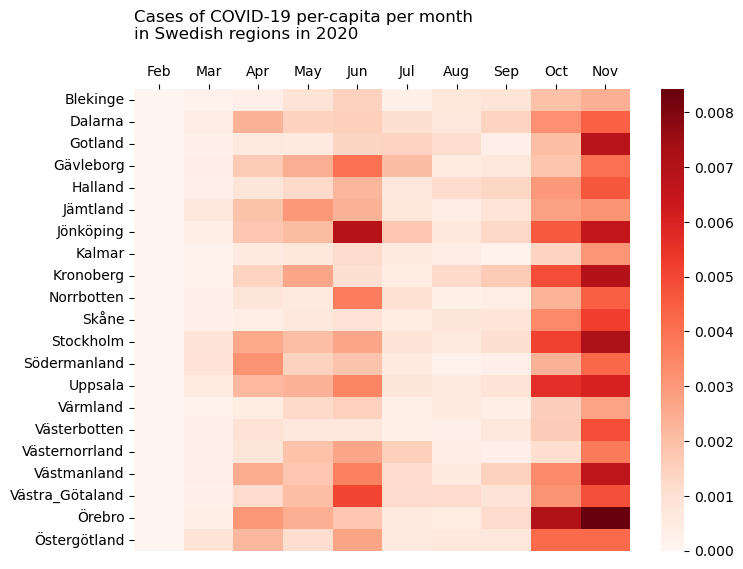

In [47]:
# figure
fig, ax = plt.subplots(figsize=(8, 6))

# plot heatmap
sns.heatmap(df_heat, cmap='Reds')
           
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
plt.xticks(np.arange(10) + .5, labels=xticks_labels)

# axis labels
plt.xlabel('')
plt.ylabel('')

# title
title = 'Cases of COVID-19 per-capita per month\nin Swedish regions in 2020\n'
plt.title(title, loc='left', size=12)
plt.show()

In [48]:
heat2 = ALLTABLES[['month', 'iso3166-2_name_en', 'TempCelc']]

df_heat2 = heat2.groupby(['month', 'iso3166-2_name_en']).mean()
df_heat2 = df_heat2.unstack(level=0)

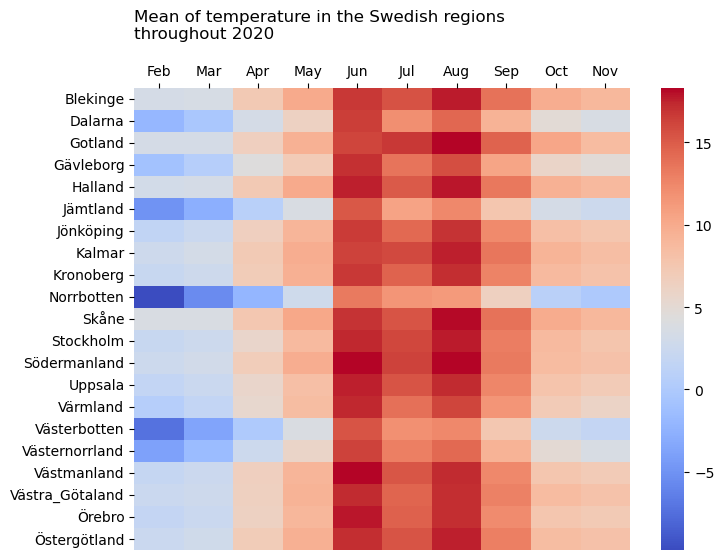

In [49]:
# figure
fig, ax = plt.subplots(figsize=(8, 6))

# plot heatmap
sns.heatmap(df_heat2, cmap='coolwarm')
           
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
plt.xticks(np.arange(10) + .5, labels=xticks_labels)

# axis labels
plt.xlabel('')
plt.ylabel('')

# title
title = 'Mean of temperature in the Swedish regions\nthroughout 2020\n'
plt.title(title, loc='left', size=12)
plt.show()

And when we look at the number of cases versus the temperature there is a pattern as well. This would be interesting to explore further.

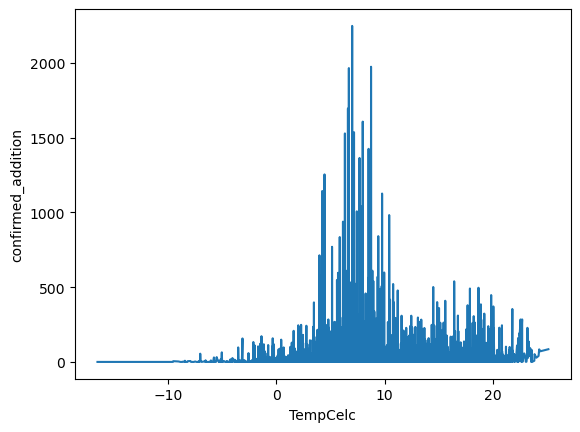

In [50]:
sns.lineplot(data=ALLTABLES, y='confirmed_addition', x='TempCelc');

## Population, total cases and cases per capita

In [51]:
# sort regions by population
REGIONS_SE = pd.DataFrame(META['country_metadata'])
regions_sorted = REGIONS_SE.sort_values(by=['population'], ascending=False)

# new data frame with total percapita cases by region
cpc = ALLTABLES[['iso3166-2_name_en', 'population', 'cases_percapita']].groupby('iso3166-2_name_en', as_index=False)
cpc_sum = cpc.mean()
cpc_sorted = cpc_sum.sort_values(by=['cases_percapita'], ascending=False)

c = ALLTABLES[['iso3166-2_name_en', 'population', 'confirmed_addition']].groupby('iso3166-2_name_en', as_index=False)
c_sum = c.mean()
c_sorted = c_sum.sort_values(by=['confirmed_addition'], ascending=False)

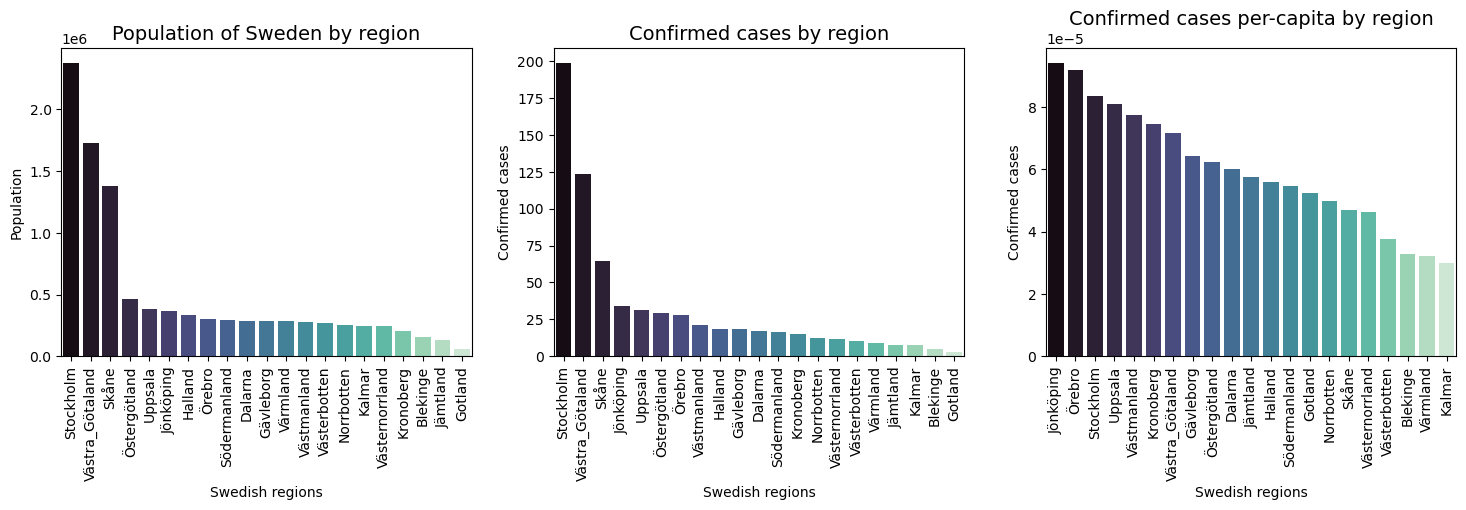

In [52]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

sns.barplot(ax=axes[0], x='iso3166-2_name_en', y='population', data=regions_sorted, palette="mako", capsize=.2)
axes[0].set_xlabel("Swedish regions")
axes[0].set_ylabel("Population")
axes[0].set_title("Population of Sweden by region", size=14)
axes[0].tick_params(labelrotation=90, axis='x')

# plotting the data to compare with the population of regions
sns.barplot(ax=axes[1], x='iso3166-2_name_en', y='confirmed_addition', data=c_sorted, palette="mako", capsize=.2)
axes[1].set_xlabel("Swedish regions")
axes[1].set_ylabel("Confirmed cases")
axes[1].set_title("Confirmed cases by region", size=14)
axes[1].tick_params(labelrotation=90, axis='x')

# plotting the data to compare with the population of regions
sns.barplot(ax=axes[2], x='iso3166-2_name_en', y='cases_percapita', data=cpc_sorted, palette="mako", capsize=.2)
axes[2].set_xlabel("Swedish regions")
axes[2].set_ylabel("Confirmed cases")
axes[2].set_title("Confirmed cases per-capita by region", size=14)
axes[2].tick_params(labelrotation=90, axis='x')


### Correlation between population size and number of cases

In [53]:
byreg = ALLTABLES[['iso3166-2_name_en', 'population', 'confirmed_addition', 'cases_percapita']].groupby('iso3166-2_name_en', as_index=True).agg({'population': "mean", 'confirmed_addition': "sum", 'cases_percapita': "sum"})
byreg

population  confirmed_addition  cases_percapita
iso3166-2_name_en                                                 
Blekinge             159606.0                1439         0.009016
Dalarna              287966.0                4771         0.016568
Gotland               59686.0                 864         0.014476
Gävleborg            287382.0                5097         0.017736
Halland              333848.0                5151         0.015429
Jämtland             130810.0                2074         0.015855
Jönköping            363599.0                9453         0.025998
Kalmar               245446.0                2029         0.008267
Kronoberg            201469.0                4142         0.020559
Norrbotten           250093.0                3450         0.013795
Skåne               1377827.0               17814         0.012929
Stockholm           2377081.0               54862         0.023080
Södermanland         297540.0                4498         0.015117
Uppsala              383713.0                8593         0.022394
Värmland             282414.0                2508         0.008881
Västerbotten         271736.0                2828         0.010407
Västernorrland       245347.0                3132         0.012766
Västmanland          275845.0                5901         0.021392
Västra_Götaland     1725881.0               34099         0.019757
Örebro               304805.0                7736         0.025380
Östergötland         465495.0                8030         0.017250

In [54]:
byreg_rank = byreg.rank(axis=0, method='average', na_option='keep', ascending=False, pct=False)
byreg_rank['diff_rank'] = byreg_rank['population'] - byreg_rank['cases_percapita']
# if diff_rank is a negative value it means there's a higher population than cases per capita
# the higher the absolute value the bigger the discrepancies between population and number of cases per-capita
byreg_rank

population  confirmed_addition  cases_percapita  diff_rank
iso3166-2_name_en                                                            
Blekinge                 19.0                20.0             19.0        0.0
Dalarna                  10.0                11.0             10.0        0.0
Gotland                  21.0                21.0             14.0        7.0
Gävleborg                11.0                10.0              8.0        3.0
Halland                   7.0                 9.0             12.0       -5.0
Jämtland                 20.0                18.0             11.0        9.0
Jönköping                 6.0                 4.0              1.0        5.0
Kalmar                   16.0                19.0             21.0       -5.0
Kronoberg                18.0                13.0              6.0       12.0
Norrbotten               15.0                14.0             15.0        0.0
Skåne                     3.0                 3.0             16.0      -13.0
Stockholm                 1.0                 1.0              3.0       -2.0
Södermanland              9.0                12.0             13.0       -4.0
Uppsala                   5.0                 5.0              4.0        1.0
Värmland                 12.0                17.0             20.0       -8.0
Västerbotten             14.0                16.0             18.0       -4.0
Västernorrland           17.0                15.0             17.0        0.0
Västmanland              13.0                 8.0              5.0        8.0
Västra_Götaland           2.0                 2.0              7.0       -5.0
Örebro                    8.0                 7.0              2.0        6.0
Östergötland              4.0                 6.0              9.0       -5.0

In [55]:
byreg.corr(method='spearman').loc[:,['population']]

population
population            1.000000
confirmed_addition    0.920779
cases_percapita       0.494805

## Number of cases, intensive care addmissions and deaths by different demographics

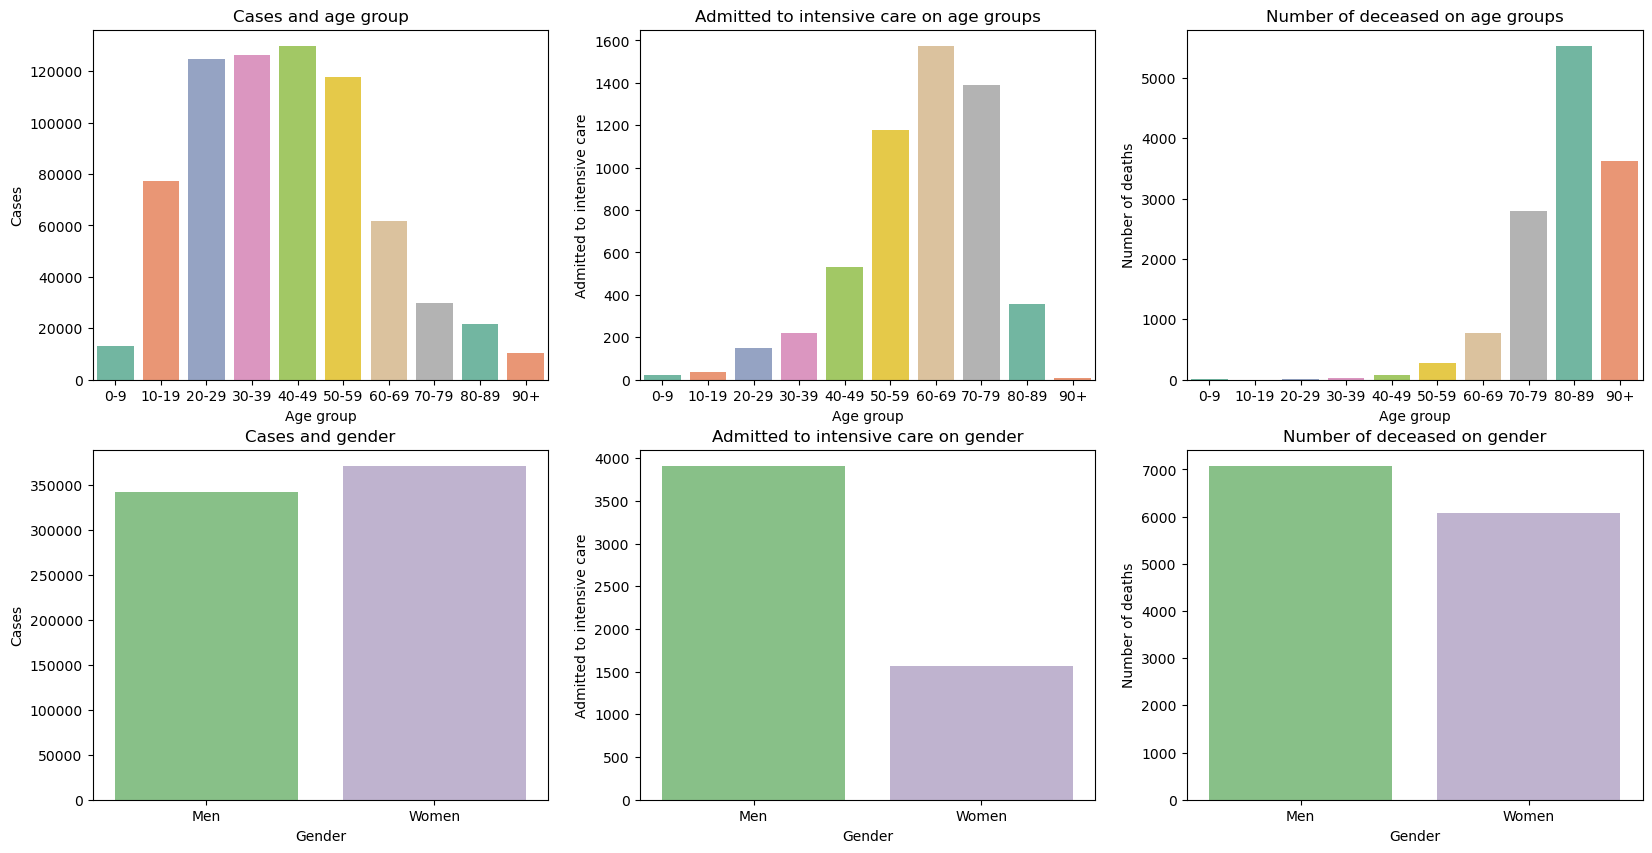

In [56]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
ages = ['0-9', '10-19', '20-29', '30-39','40-49', '50-59', '60-69', '70-79', '80-89', '90+']
gender = ['Men', 'Women']


sns.barplot(ax = axes[0,0], x ='Age group', y='cases',  data = AGE.drop(10), palette = 'Set2')
axes[0,0].set_xticklabels(ages)
axes[0,0].set_ylabel('Cases')
axes[0,0].set_title('Cases and age group')

sns.barplot(ax = axes[0,1], x= 'Age group', y ='intensive_care',  data = AGE.drop(10), palette = 'Set2')
axes[0,1].set_xticklabels(ages)
axes[0,1].set_ylabel('Admitted to intensive care')
axes[0,1].set_title('Admitted to intensive care on age groups')

sns.barplot(ax = axes[0,2], x='Age group', y='deceased',  data = AGE.drop(10), palette = 'Set2')
axes[0,2].set_xticklabels(ages)
axes[0,2].set_ylabel('Number of deaths')
axes[0,2].set_title('Number of deceased on age groups')


sns.barplot(ax = axes[1,0], x ='gender', y='cases',  data = GENDER.drop(2), palette = "Accent")
axes[1,0].set_xticklabels(gender)
axes[1,0].set_ylabel('Cases')
axes[1,0].set_xlabel('Gender')
axes[1,0].set_title('Cases and gender')

sns.barplot(ax = axes[1,1], x= 'gender', y ='intensive_care',  data = GENDER.drop(2), palette = "Accent")
axes[1,1].set_xticklabels(gender)
axes[1,1].set_ylabel('Admitted to intensive care')
axes[1,1].set_xlabel('Gender')
axes[1,1].set_title('Admitted to intensive care on gender')


sns.barplot(ax = axes[1,2], x='gender', y='deceased',  data = GENDER.drop(2), palette = "Accent")
axes[1,2].set_xticklabels(gender)
axes[1,2].set_ylabel('Number of deaths')
axes[1,2].set_xlabel('Gender')
axes[1,2].set_title('Number of deceased on gender');

# Maps
Plotting the number on the map gives a really good visualisation of what we had found through in the correlation analysis earlier, the total cases and population maps are almost identical, but when we look at cases per capita the map shows a very different picture.

## COVID-19 cases and population

In [31]:
ALL_REG = ALLTABLES[['iso3166-2','iso3166-2_name_en', 'confirmed_addition', 'cases_percapita']].groupby(by = "iso3166-2").sum().reset_index()

m_casetotal = folium.Map(location = [62.9, 19.3], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "Number of confirmed cases",
    data = ALL_REG,
    columns = ["iso3166-2", "confirmed_addition"],
    key_on = "properties.iso_3166_2",
    fill_color = "Reds",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of confirmed cases",
).add_to(m_casetotal)

m_casetotal

/tmp/ipykernel_8237/274725047.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ALL_REG = ALLTABLES[['iso3166-2','iso3166-2_name_en', 'confirmed_addition', 'cases_percapita']].groupby(by = "iso3166-2").sum().reset_index()


In [58]:
POP_REG = ALLTABLES[['iso3166-2','iso3166-2_name_en', 'population']].groupby(by = "iso3166-2").mean().reset_index()

m_pop = folium.Map(location = [62.9, 19.3], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "Population of Swedish regions",
    data = POP_REG,
    columns = ["iso3166-2", "population"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlGn",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Population",
).add_to(m_pop)

m_pop

/tmp/ipykernel_8237/1655405791.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  POP_REG = ALLTABLES[['iso3166-2','iso3166-2_name_en', 'population']].groupby(by = "iso3166-2").mean().reset_index()


In [59]:
ALL_REG = ALLTABLES[['iso3166-2','iso3166-2_name_en', 'confirmed_addition', 'cases_percapita']].groupby(by = "iso3166-2").sum().reset_index()

n_cases = folium.Map(location = [62.9, 19.3], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "Number of confirmed cases per capita",
    data = ALL_REG,
    columns = ["iso3166-2", "cases_percapita"],
    key_on = "properties.iso_3166_2",
    fill_color = "Reds",
    fill_opacity = 0.7,
    line_opacity = 0.2,
    legend_name = "Number of confirmed cases per capita",
).add_to(n_cases)

n_cases

/tmp/ipykernel_8237/2702709549.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ALL_REG = ALLTABLES[['iso3166-2','iso3166-2_name_en', 'confirmed_addition', 'cases_percapita']].groupby(by = "iso3166-2").sum().reset_index()


## Weather per region

In [60]:
df_meanTemp_map = ALLTABLES.groupby(['iso3166-2', 'month'], as_index= False).agg({'TemperatureAboveGround': "mean" })

# mean temperature by months divided into regions  
map_temperature = folium.Map(location = [62.9, 19.3], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "MAP: MEAN TEMPERATURE (CELCIUS) BY REGION",
    data = df_meanTemp_map,
    columns = ["iso3166-2", "TemperatureAboveGround"],
    key_on = "properties.iso_3166_2",
    fill_color = "OrRd",
    fill_opacity = 0.5,
    line_opacity = 1.5,
    legend_name = "Monthly mean: Temperature (Celcius) in 2020",
).add_to(map_temperature)
map_temperature

In [61]:
df_meanHumidity_map = ALLTABLES.groupby(['iso3166-2', 'month'], as_index= False).agg({'RelativeHumiditySurface': "mean"})

# mean humidity by months divided into regions  
map_humidity = folium.Map(location = [62.9, 19.3], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "MAP: MEAN RELATIVE HUMIDITY SURFACE BY REGION",
    data = df_meanHumidity_map,
    columns = ["iso3166-2", "RelativeHumiditySurface"],
    key_on = "properties.iso_3166_2",
    fill_color = "GnBu",
    fill_opacity = 0.5,
    line_opacity = 1.5,
    legend_name = "Monthly mean: Humidity surface in 2020",
).add_to(map_humidity)

map_humidity

In [62]:
df_meanSolarradiation_map = ALLTABLES.groupby(['iso3166-2', 'month'], as_index= False).agg({'SolarRadiation': "mean"})

# mean solar radiation by months divided into regions  
map_solarRadiation = folium.Map(location = [62.935, 19.358], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "MAP: MEAN SOLAR RADIATION BY REGION",
    data = df_meanSolarradiation_map,
    columns = ["iso3166-2", "SolarRadiation"],
    key_on = "properties.iso_3166_2",
    fill_opacity = 0.5,
    line_opacity = 1.5,
    legend_name = "Monthly mean: Solar radiation in 2020",
).add_to(map_solarRadiation)

map_solarRadiation

In [63]:
df_meanUVindex_map = ALLTABLES.groupby(['iso3166-2', 'month'], as_index= False).agg({'UVIndex': "mean"})

# mean uv-index by months divided into regions  
map_uvindex = folium.Map(location = [62.935, 19.358], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "MAP: MEAN UV INDEX BY REGION",
    data = df_meanUVindex_map,
    columns = ["iso3166-2", "UVIndex"],
    key_on = "properties.iso_3166_2",
    fill_color = "YlOrRd",
    fill_opacity = 0.5,
    line_opacity = 1.5,
    legend_name = "Monthly mean: UVIndex in 2020",
).add_to(map_uvindex)

map_uvindex

In [64]:
df_meanWinspeed_map = ALLTABLES.groupby(['iso3166-2', 'month'], as_index= False).agg({'WindSpeed': "mean"})

# mean windspeed by months divided into regions  
map_windspeed = folium.Map(location = [62.935, 19.358], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "MAP: MEAN WINSPEED BY REGION",
    data = df_meanWinspeed_map,
    columns = ["iso3166-2", "WindSpeed"],
    key_on = "properties.iso_3166_2",
    fill_color = "BuGn",
    fill_opacity = 0.5,
    line_opacity = 1.5,
    legend_name = "Monthly mean: Windspeed in 2020",
).add_to(map_windspeed)

map_windspeed

In [65]:
df_meanPrecipitation_map = ALLTABLES.groupby(['iso3166-2', 'month'], as_index= False).agg({'Totalprecipitation': "mean"})

# mean precipitation by months divided into regions  
map_totalprecipitation = folium.Map(location = [62.9, 19.3], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "MAP: MEAN PRECIPITATION BY REGION",
    data = df_meanPrecipitation_map,
    columns = ["iso3166-2", "Totalprecipitation"],
    key_on = "properties.iso_3166_2",
    fill_color = "RdPu",
    fill_opacity = 0.5,
    line_opacity = 1.5,
    legend_name = "Monthly mean: Precipitation in 2020",
    
).add_to(map_totalprecipitation)

map_totalprecipitation

In [66]:
df_meanSurfacepressure_map = ALLTABLES.groupby(['iso3166-2', 'month'], as_index= False).agg({'Surfacepressure': "mean"})

# mean surface pressure by months divided into regions  
map_surfacepressure = folium.Map(location = [62.9, 19.3], zoom_start = 4.2)

folium.Choropleth(
    geo_data = GEO,
    name = "MAP: MEAN PRECIPITATION BY REGION",
    data = df_meanSurfacepressure_map,
    columns = ["iso3166-2", "Surfacepressure"],
    key_on = "properties.iso_3166_2",
    fill_color = "BuGn",
    fill_opacity = 0.5,
    line_opacity = 1.5,
    legend_name = "Monthly mean: Surfacepressure in 2020",
    
).add_to(map_surfacepressure)

map_surfacepressure